# GBDT & RF on Amazon Reviews Dataset (Part II)


## Data Source: 
**The preprocessing step has produced final.sqlite file after doing the data preparation & cleaning.** The review text is now devoid of punctuations, HTML markups and stop words.

## Objective:
**To find number of trees of Random Forest Classifier using GridSearchCV or iterated cross validation** on standardized feature vectors obtained from BoW, tf-idf, W2V and tf-idf weighted W2V featurizations.

**Use Gradient Boosted Decision Trees alongsize RF for comparison. GridSearchCV is to be done in order to tune 3 hyperparameters: # of trees, depth of the tree as well as learning rate**

Find Precision, Recall, F1 Score, Confusion Matrix, Accuracy of the optimal model obstained with GridSearch or Cross Validation, on vectorized input data, for BoW, tf-idf, W2V and tf-idf weighted W2V featurizations. TPR, TNR, FPR and FNR is calculated for all. 


## At a glance:
Tail end data is taken after sorting the data, to conserve the timing info & time Series based cross validation is done, as it is time series data. **The optimal number of trees for Random Forest Classifier is found using GridSearchCV (wrote code for cross validation also), by searching for # of trees between 9 - 135, with step size 9.**

GBDT is also done along with RF. The **optimal parameters for GBDT is found using GridSearchCV.  Parameter tuning of 3 hyperparameters is done**: # of trees between 20-81 (with step size 10), max_depth between 5-16 (with step size 2) & learning_rate between 0.05 - 0.2 (with step size 0.05). 

The Precision, Recall, F1 Score, Confusion Matrix, Accuracy metrics are found out for all 4 featurizations.<br><br>

# Preprocessed Data Loading

In [11]:
#loading libraries for LR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation

#loading libraries for scikit learn, nlp, db, plot and matrix.
import sqlite3
import pdb
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import tree

from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

print(final.head(2))

    index      Id   ProductId          UserId      ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL  shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U            Tracy   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   

                                         CleanedText  
0  b'witti littl book make son laugh loud recit c...  
1  b'grew read sendak book watch realli rosi movi...  




# Random Sampling & Time Based Slicing

In [12]:
# To randomly sample the data and sort based on time before doing train/ test split.
# The slicing into train & test data is done thereafter.

num_points = 20000

# used to format headings 
bold = '\033[1m'
end = '\033[0m'

# you can use random_state for reproducibility
# sampled_final = final.sample(n=num_points, random_state=2)

#Sorting data according to Time in ascending order
sorted_final = final.sort_values('Time', axis=0, 
                ascending=True, inplace=False, kind='quicksort', na_position='first')

selected_final = sorted_final.tail(num_points)

# fetching the outcome class 
y = selected_final['Score'] 

def class2num(response):
    if (response == 'positive'):
        return 1
    else:
        return 0

y_bin = list(map(class2num, y))

X_train, X_test, y_train, y_test = train_test_split(
            selected_final, y_bin, test_size=0.3, random_state=42)


# Custom Defined Functions

4 user defined functions are written to 

    a) Random Forest Hyperparameter Tuning

    b) Gradient Boosted Decision Tree (GBDT) Hyperparameter Tuning
    
    c) Compute Performance Metrics for RF & GBDT
    
    d) Generate Word Cloud based on Feature Importance

## a) Random Forest Hyperparameter Tuning

In [16]:
# source: https://chrisalbon.com/machine_learning/
# model_selection/hyperparameter_tuning_using_random_search/
# some parts of the below code are from the above link.

# Part of Decision tree code is taken from here.
# https://towardsdatascience.com/random-useful-scikit-learn-methods-a032f78e1ec3

# Cross Validation using GridSearchCV

import numpy 
import math
from scipy.stats import uniform
import matplotlib.pyplot as plt 
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import scipy

def rfGridCV(X_train_vect, X_test_vect, genCloud = False, title_cf=''):
    
    # empty list that will hold cv scores
    cv_scores = []
    
    # search for trees between 9 - 135, step size 9
    n_trees = list(range(9, 136, 9))

    # to do time_series based CV, as it is time series data.
    tscv = TimeSeriesSplit(n_splits=10)
    
    # Use a grid over parameters of interest
    param_grid = {"n_estimators" : n_trees}

    CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), 
                              param_grid=param_grid, cv=tscv)
    CV_rfc.fit(X_train_vect, y_train)
    print (CV_rfc.best_params_)

    print("**RF Grid Search Results**")
    print("Best Training Accuracy:\t", CV_rfc.best_score_)
    print("Best Parameters:\t", CV_rfc.best_params_)
    print("Best Estimator:\t", CV_rfc.best_estimator_)
    print("CV Results:\t", CV_rfc.cv_results_.keys())
    means = CV_rfc.cv_results_['mean_test_score']
    
    optimal_ntrees   = CV_rfc.cv_results_[
                        'params'][means.argmax()].get('n_estimators')
    
    # Hyperparameters
        #     depth_range = range(1, 25)
        #     param_grid = dict(max_depth=depth_range)


        #     # perform 10-fold cross validation
        #     for d in depth_range:

        #         dt = tree.DecisionTreeClassifier(max_depth=d)

        #         scores = cross_val_score(dt, 
        #                         X_train_vect, y_train, cv=tscv, scoring='accuracy')
        #         cv_scores.append(scores.mean())
        #         print(scores.mean())

        #     # changing to misclassification error
        #     MSE = [1 - x for x in cv_scores]

        #     print(MSE.index(min(MSE)))
        #     # determining best k
        #     optimal_d = depth_range[MSE.index(min(MSE))]
        #     print('\nThe optimal depth is %d.' % optimal_d)

        #     plt.figure()
        #     plt.title('Cross Validation Plot: Depth vs CV Error')
        #     plt.plot(depth_range, MSE)
        #     plt.show()
    
    optimal_clf = RandomForestClassifier(n_estimators=optimal_ntrees)
    optimal_clf.fit(X_train_vect, y_train)
    
    compute_metrics(optimal_clf, X_test_vect, 
                    title_cf="Confusion Matrix: GridSearchCV")
    
    if genCloud:
        return optimal_clf
    

# b) GBDT Hyperparameter Tuning

In [17]:

# source: got from below link and modified.
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

from sklearn.ensemble import GradientBoostingClassifier

def gbdtGridCV(X_train_vect, X_test_vect, genCloud = False, title_cf=''):
    
    # empty list that will hold cv scores
    cv_scores = []

    # to do time_series based CV, as it is time series data.
    tscv = TimeSeriesSplit(n_splits=10)
    
    param_test = {'n_estimators':range(20,81,10), 
                  'max_depth':range(5,16,2), 
                  'learning_rate': list(np.arange(0.05,0.2,0.05))}
    
    gbSearch = GridSearchCV(estimator = GradientBoostingClassifier(
                min_samples_split=500,min_samples_leaf=50,max_features='sqrt'), 
                param_grid = param_test, scoring='roc_auc', cv=10)
    
    gbSearch.fit(X_train_vect, y_train)
    optimal_ntrees   = gbSearch.best_params_.get('n_estimators')
    optimal_max_depth = gbSearch.best_params_.get('max_depth')
    optimal_learning_rate = gbSearch.best_params_.get('learning_rate')
    
    print("**GBDT Grid Search Results**")
    print("Optimal Number of Trees:\t", optimal_ntrees)
    print("Optimal Max Depth:\t", optimal_max_depth)
    print("Optimal Learning Rate:\t", optimal_learning_rate)
    
    # Hyperparameters
        #     depth_range = range(1, 25)
        #     param_grid = dict(max_depth=depth_range)


        #     # perform 10-fold cross validation
        #     for d in depth_range:

        #         dt = tree.DecisionTreeClassifier(max_depth=d)

        #         scores = cross_val_score(dt, 
        #                         X_train_vect, y_train, cv=tscv, scoring='accuracy')
        #         cv_scores.append(scores.mean())
        #         print(scores.mean())

        #     # changing to misclassification error
        #     MSE = [1 - x for x in cv_scores]

        #     print(MSE.index(min(MSE)))
        #     # determining best k
        #     optimal_d = depth_range[MSE.index(min(MSE))]
        #     print('\nThe optimal depth is %d.' % optimal_d)

        #     plt.figure()
        #     plt.title('Cross Validation Plot: Depth vs CV Error')
        #     plt.plot(depth_range, MSE)
        #     plt.show()
    
    optimal_clf = GradientBoostingClassifier(learning_rate = optimal_learning_rate, 
                               max_depth = optimal_max_depth,
                               n_estimators = optimal_ntrees, 
                               min_samples_split=500,
                               min_samples_leaf=50,max_features='sqrt')
    optimal_clf.fit(X_train_vect, y_train)
    
    compute_metrics(optimal_clf, X_test_vect, 
                    title_cf="Confusion Matrix: GridSearchCV")
    
    if genCloud:
        return optimal_clf
    

## c) Compute Performance Metrics for RF & GBDT

In [18]:
# ========================== LR with alpha = optimal_alpha ============================
#To compute the performance metrics for RF & GBDT

import seaborn as sn
from sklearn.metrics import *

def compute_metrics(dt_optimal, X_test_vect, title_cf="Confusion Matrix"):

    # predict the response
    pred = dt_optimal.predict(X_test_vect)

    print(bold + '\n\nMetric Analysis of DT Classifier' + end)
    
    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nAccuracy \t= %f' % acc)
    
    precision = precision_score(y_test, pred) * 100
    print('Precision \t= %f' % precision)
    
    recall = recall_score(y_test, pred) * 100
    print('Recall \t\t= %f' % recall)
    
    f1score = f1_score(y_test, pred) * 100
    print('F1 Score \t= %f' % f1score)
    
    confusion = confusion_matrix(y_test, pred)
    print(bold + "\n\nConfusion Matrix" + end)
    
    plt.figure()
    plt.title(title_cf)
    df_cm = pd.DataFrame(confusion, range(2), range(2))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="d")# font size
    
    (tn, fp, fn, tp) = confusion.ravel()
    print("\nTrue Negatives = " + str(tn))
    print("True Positives = " + str(tp))
    print("False Negatives = " + str(fn))
    print("False Positives = " + str(fp))
    
    actual_positives = tp+fn
    actual_negatives = tn+fp
    print("\nTotal Actual Positives = " + str(actual_positives))
    print("Total Actual Negatives = " + str(actual_negatives))
    
    print("\nTrue Positive Rate(TPR) = " + str(round(tp/actual_positives, 2)))
    print("True Negative Rate(TNR) = " + str(round(tn/actual_negatives, 2)))
    print("False Positive Rate(FPR) = " + str(round(fp/actual_negatives, 2)))
    print("False Negative Rate(FNR) = " + str(round(fn/actual_positives, 2)))
    

# d) Generate Word Cloud based on Feature Importance

In [20]:
# taken word cloud src from here:
# https://stackoverflow.com/questions/43043437/wordcloud-python-with-generate-from-frequencies
# modified for creating the dictionary of importance.

from wordcloud import WordCloud
    
def generateCloud(clf, vect):
    
    clf.fit(X_train_vect, y_train)
    
    feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = vect.get_feature_names(),
                                    columns=['importance']).sort_values(
                                             'importance',ascending=False)
    
    print(feature_importances.size)
    # remove features with importance = 0
    feature_importances = feature_importances.loc[
                            ~(feature_importances==0).all(axis=1)]

    # create the word cloud with feature importance as the scaling factor
    wordcloud = WordCloud(width=2200,height=1200, 
                  max_words=2000,relative_scaling=1,
                  normalize_plurals=False).generate_from_frequencies(
                                dict(feature_importances)['importance'])
    
    plt.figure(figsize =[16, 12])
    plt.title('Most Important Features in Amazon Reviews')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


# BoW

BoW will result in a **sparse matrix with huge number of features** as it creates a feature for each unique word in the review.

For Binary BoW feature representation, CountVectorizer is declared as float, as the values can take non-integer values on further processing. 



1) Grid Search CV using RF Classifier on BoW
{'n_estimators': 36}
**RF Grid Search Results**
Best Training Accuracy:	 0.8679245283018868
Best Parameters:	 {'n_estimators': 36}
Best Estimator:	 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=36, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
CV Results:	 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_

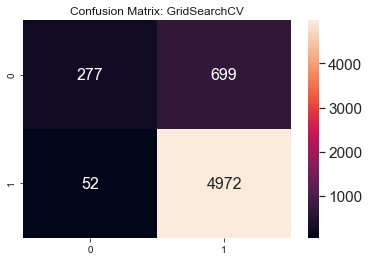

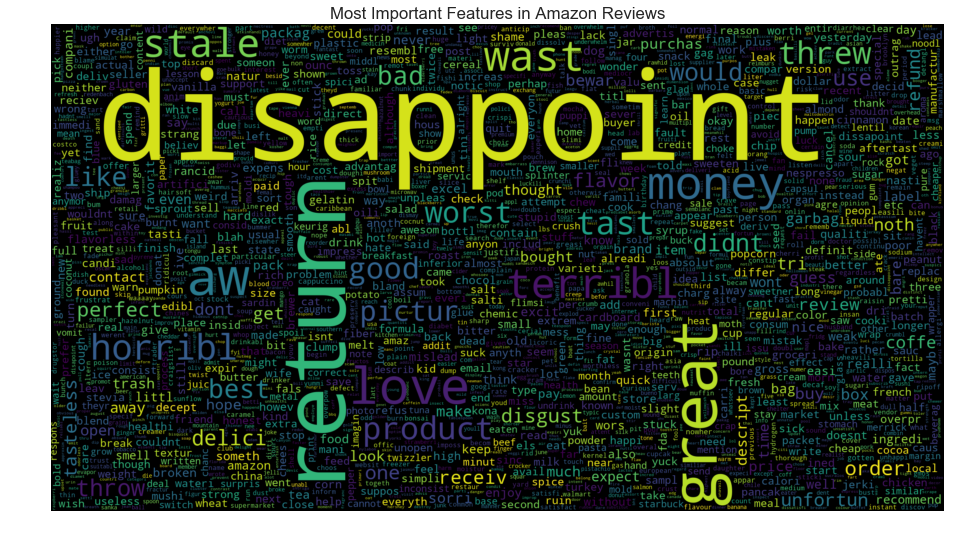



2) Grid Search CV using GBDT Classifier on BoW
**GBDT Grid Search Results**
Optimal Number of Trees:	 70
Optimal Max Depth:	 15
Optimal Learning Rate:	 0.2


Metric Analysis of DT Classifier

Accuracy 	= 89.233333
Precision 	= 90.047567
Recall 		= 97.969745
F1 Score 	= 93.841754


Confusion Matrix

True Negatives = 432
True Positives = 4922
False Negatives = 102
False Positives = 544

Total Actual Positives = 5024
Total Actual Negatives = 976

True Positive Rate(TPR) = 0.98
True Negative Rate(TNR) = 0.44
False Positive Rate(FPR) = 0.56
False Negative Rate(FNR) = 0.02
14494


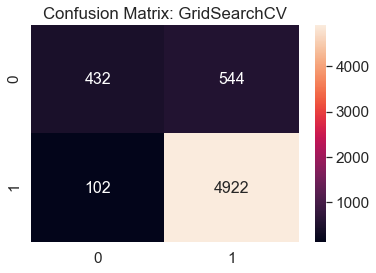

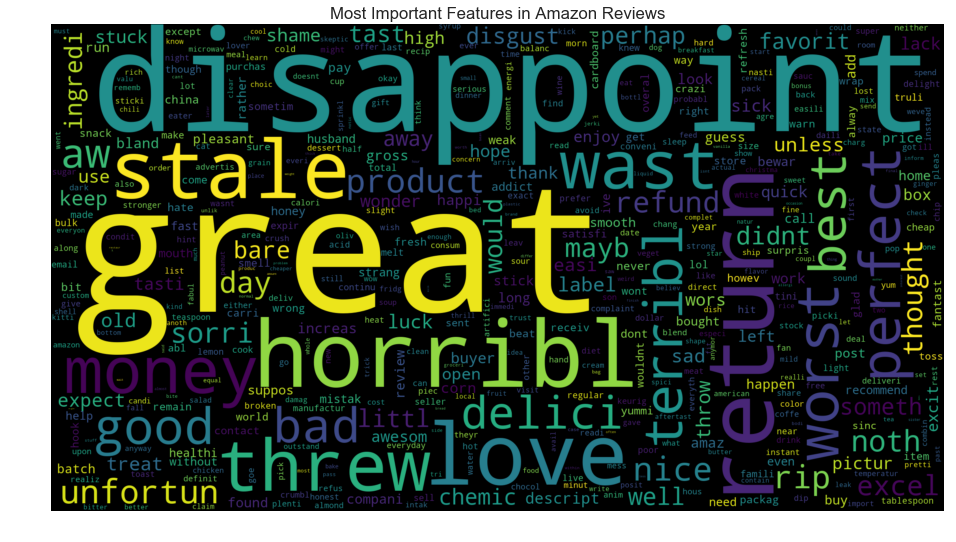

In [7]:
# BoW Featurisation, Standardisation, Grid Search 

from sklearn.random_projection import sparse_random_matrix

#BoW
count_vect = CountVectorizer(dtype="float") #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_vect.get_shape()

#BoW Test
X_test_vect = count_vect.transform(X_test['CleanedText'].values)

# Standardisation is not required for DTs, GBDTs & RF

print(bold + "\n\n1) Grid Search CV using RF Classifier on BoW"+ end)

# Do grid Search using Random Forest Classifier. 
# The function computes the performance metrics also
clf = rfGridCV(X_train_vect, X_test_vect, genCloud=True)
generateCloud(clf, count_vect)

print(bold + "\n\n2) Grid Search CV using GBDT Classifier on BoW"+ end)

# Do grid Search using GBDT Classifier.  
# The function computes the performance metrics also
clf = gbdtGridCV(X_train_vect, X_test_vect, genCloud=True)
generateCloud(clf, count_vect)



# tf-IDF 

**Sparse matrix generated from tf-IDF ** is fed in to GridSearch GBDT Cross Validator & RF Cross Validator to find the optimal depth value. Performance metrics of optimal GBDT with tf-idf featurization is found.



1) Grid Search CV using RF Classifier on tf-idf
{'n_estimators': 18}
**RF Grid Search Results**
Best Training Accuracy:	 0.8647012578616352
Best Parameters:	 {'n_estimators': 18}
Best Estimator:	 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
CV Results:	 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_te

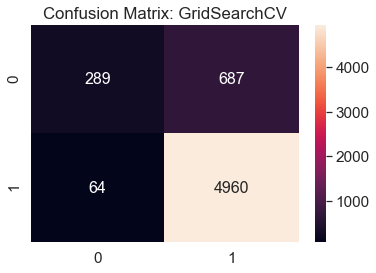

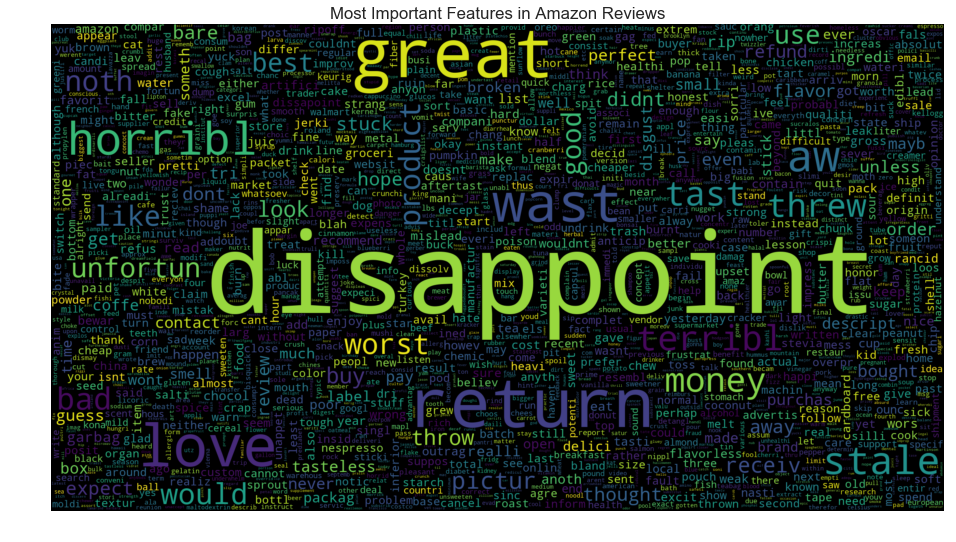



2) Grid Search CV using GBDT Classifier on tf-idf
**GBDT Grid Search Results**
Optimal Number of Trees:	 80
Optimal Max Depth:	 15
Optimal Learning Rate:	 0.2


Metric Analysis of DT Classifier

Accuracy 	= 89.783333
Precision 	= 90.774635
Recall 		= 97.730892
F1 Score 	= 94.124413


Confusion Matrix

True Negatives = 477
True Positives = 4910
False Negatives = 114
False Positives = 499

Total Actual Positives = 5024
Total Actual Negatives = 976

True Positive Rate(TPR) = 0.98
True Negative Rate(TNR) = 0.49
False Positive Rate(FPR) = 0.51
False Negative Rate(FNR) = 0.02
14494


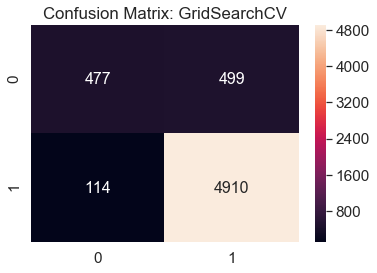

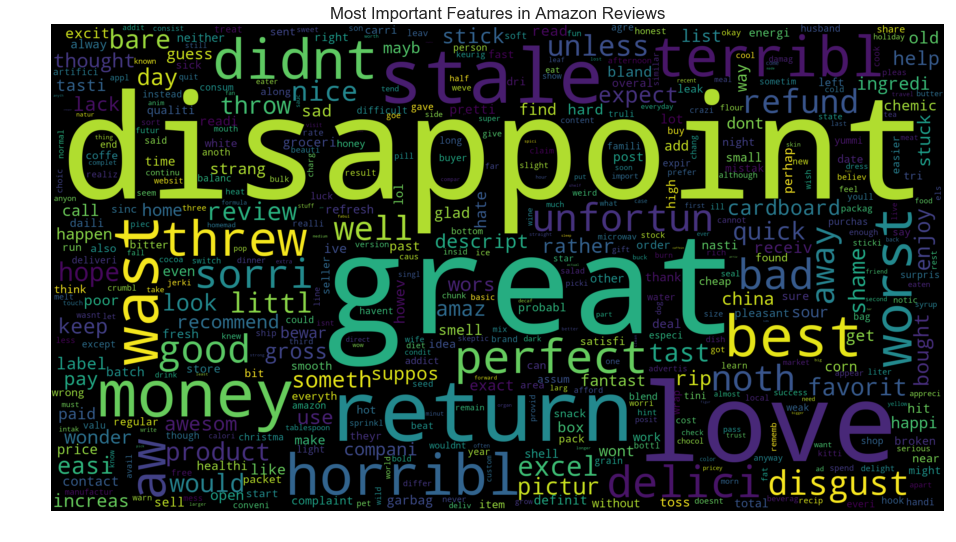

In [8]:
# TFID Featurisation, Standardisation, Grid Search 

from sklearn.random_projection import sparse_random_matrix

# TFID
count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_vect.get_shape()

# TFID Test
X_test_vect = count_vect.transform(X_test['CleanedText'].values)

# Standardisation is not required for DTs, GBDTs & RF

print(bold + "\n\n1) Grid Search CV using RF Classifier on tf-idf"+ end)

# Do grid Search using Random Forest Classifier. 
# The function computes the performance metrics also
clf = rfGridCV(X_train_vect, X_test_vect, genCloud=True)
generateCloud(clf, count_vect)

print(bold + "\n\n2) Grid Search CV using GBDT Classifier on tf-idf"+ end)

# Do grid Search using GBDT Classifier.  
# The function computes the performance metrics also
clf = gbdtGridCV(X_train_vect, X_test_vect, genCloud=True)
generateCloud(clf, count_vect)


# Word2Vec

**Dense matrix generated from Word2Vec ** is fed in to GridSearch GBDT Cross Validator & RF Cross Validator to find the optimal depth value. Performance metrics of GBDT and RF with W2V featurization is found. 


In [21]:
# Train your own Word2Vec model using your own text corpus
import gensim
import re

w2v_dim = 300

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

def trainW2V_model(reviewText):
    #select subset of points for fast execution
    i=0
    list_of_sent=[]

    for sent in reviewText:
        sent = str(sent, 'utf-8')
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):    
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue 
        list_of_sent.append(filtered_sentence)

    w2v_model=gensim.models.Word2Vec(list_of_sent,
                                     min_count=5,size=w2v_dim, workers=4) 
    
    return w2v_model

In [22]:
# average Word2Vec
# compute average word2vec for each review.

def computeAvgW2V(w2vTrained_model, reviewText):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

    for sent in reviewText: # for each review/sentence
        sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        sent = str(sent, 'utf-8')
        sent = re.sub("[^\w]", " ",  sent).split()

        for word in sent: # for each word in a review/sentence
            try:
                vec = w2vTrained_model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    return np.nan_to_num(sent_vectors)


C:\Users\Anand\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide




1) Grid Search CV using RF Classifier
{'n_estimators': 108}
**RF Grid Search Results**
Best Training Accuracy:	 0.8585691823899371
Best Parameters:	 {'n_estimators': 108}
Best Estimator:	 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=108, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
CV Results:	 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_s

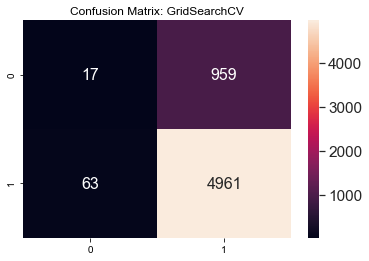

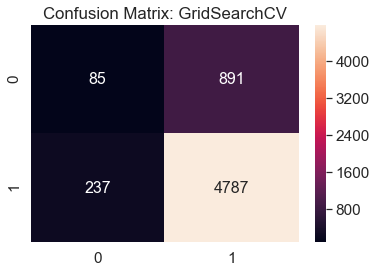

In [23]:
# W2V Main Function
# W2V Featurisation, Standardisation, Grid Search and Random Search, 
# Perturbation test to remove multicollinear features

from sklearn.preprocessing import StandardScaler

# W2V Train
w2v_trainModel = trainW2V_model(X_train['CleanedText'].values)
X_train_vect = computeAvgW2V(w2v_trainModel, X_train['CleanedText'].values)

# W2V Test
w2v_testModel = trainW2V_model(X_test['CleanedText'].values)
X_test_vect = computeAvgW2V(w2v_testModel, X_test['CleanedText'].values)

# Standardisation is not required for DTs

# Do grid Search using RF & GBDT Classifier.  
# The function computes the performance metrics also
print(bold + "\n\n1) Grid Search CV using RF Classifier"+ end)
rfGridCV(X_train_vect, X_test_vect)

print(bold + "\n\n2) Grid Search CV using GBDT Classifier"+ end)
gbdtGridCV(X_train_vect, X_test_vect)

# TF-ID Weighted W2V

In [24]:
# average Word2Vec
# compute average word2vec for each review.

def compute_tfidW2V(w2v_model, model_tf_idf, count_vect, reviewText):

    # the tfidf-w2v for each sentence/review is stored in this list
    tfidf_sent_vectors = []; 
    row=0; 
    
    # TF-IDF weighted Word2Vec
    tfidf_feats = count_vect.get_feature_names() # tfidf words/col-names

    # iterate for each review/sentence
    for sent in reviewText: 
        sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        sent = str(sent, 'utf-8')
        sent = re.sub("[^\w]", " ",  sent).split()
        
        for word in sent: # for each word in a review/sentence
            try:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                tfidf = model_tf_idf[row, tfidf_feats.index(word)]
                sent_vec += (vec * tfidf)
                weight_sum += tfidf
            except:
                pass
        sent_vec /= weight_sum

        tfidf_sent_vectors.append(sent_vec)
        row += 1

    return np.nan_to_num(tfidf_sent_vectors)


C:\Users\Anand\Anaconda3\envs\myenv\lib\site-packages\sklearn\feature_extraction\text.py:1547: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float 'dtype' will be converted to np.float64.
  UserWarning)
C:\Users\Anand\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide




1) Grid Search CV using RF Classifier
{'n_estimators': 90}
**RF Grid Search Results**
Best Training Accuracy:	 0.8481132075471698
Best Parameters:	 {'n_estimators': 90}
Best Estimator:	 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
CV Results:	 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_scor

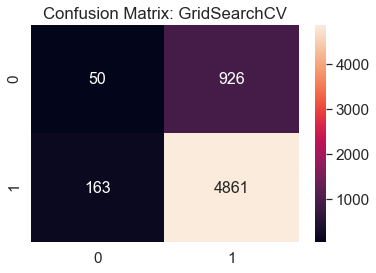

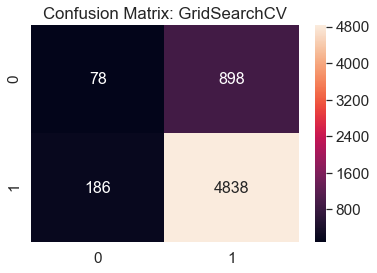

In [25]:
# tf-df weighted W2V Main Function
# tfidf and W2V Featurisation, Standardisation, Grid Search 
# Perturbation test to remove multicollinear features

from sklearn.preprocessing import StandardScaler

# TFID
count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
X_train_tfid_vect = count_vect.fit_transform(X_train['CleanedText'].values)

# TFID Test
X_test_tfid_vect = count_vect.transform(X_test['CleanedText'].values)


X_train_vect = compute_tfidW2V(w2v_trainModel, X_train_tfid_vect, 
                               count_vect, X_train['CleanedText'].values)
X_test_vect = compute_tfidW2V(w2v_testModel, X_test_tfid_vect, 
                              count_vect, X_test['CleanedText'].values)

# Standardisation is not required for DTs

# Do both grid Search and Random Search. 
# The function computes the performance metrics also
print(bold + "\n\n1) Grid Search CV using RF Classifier"+ end)
rfGridCV(X_train_vect, X_test_vect)

print(bold + "\n\n2) Grid Search CV using GBDT Classifier"+ end)
gbdtGridCV(X_train_vect, X_test_vect)



# Summary Statistics

 Model | Optimal Parameters | Test Metric |
------------- |:----------:|:-----------------:|
**RF on BoW** | Number of trees: 36 | **Accuracy = 87.48, F1 Score = 92.97** <br>TPR = 0.99, TNR = 0.28, FPR = 0.72, FNR = 0.01|
**GBDT on BoW** | Number of Trees: 70, Max Depth: 15, Learning Rate: 0.2 | **Accuracy = 89.23, F1 Score = 93.84** <br>TPR = 0.98, TNR = 0.44, FPR = 0.56, FNR = 0.02|
**RF on tf-idf** | Number of trees: 18 | **Accuracy = 87.48, F1 Score = 92.96** <br>TPR = 0.99, TNR = 0.3, FPR = 0.7, FNR = 0.01|
**GBDT on tf-idf** | Number of Trees: 80, Max Depth: 15, Learning Rate: 0.2 | **Accuracy = 89.78, F1 Score = 94.12 <br>TPR = 0.98, TNR = 0.49, FPR = 0.51, FNR = 0.02**|
**RF on W2V** | Number of trees: 108 | **Accuracy = 82.96, F1 Score = 90.66** <br>TPR = 0.99, TNR = 0.02, FPR = 0.98, FNR = 0.01|
**GBDT on W2V** | Number of Trees: 80, Max Depth: 7, Learning Rate: 0.1 | **Accuracy = 81.2, F1 Score = 89.46** <br>TPR = 0.95, TNR = 0.09, FPR = 0.91, FNR = 0.05|
**RF on tf-idf W2V** | Number of trees: 90 | **Accuracy = 82.96, F1 Score = 90.66** <br>TPR = 0.99, TNR = 0.02, FPR = 0.98, FNR = 0.01|
**GBDT on tf-idf W2V** | Number of Trees: 90, Max Depth: 7, Learning Rate: 0.1 | **Accuracy = 81.85, F1 Score = 89.93** <br>TPR = 0.97, TNR = 0.05, FPR = 0.95, FNR = 0.03|

# Observations

1) The **best model** based on test metrics is found to be **GBDT on tf-idf**. The F1 Score is **94.12**, while **98% of positive points and around 50% of negative points** are detected correctly.

2) The **classification accuracy of GBDT and RF is found to be less than linear models** like logistic regression. This is possibly because the **separation at high dimensional space using hyperplanes is easier** than doing a decision tree based approach.

3) **GBDT consistently performs better than RF** for Amazon review classiciation problem.

4) The **wordcloud figure of GBDT is much clearer than RF**. RF wordcloud is too cluttered and hence less suitable. 

5) **Words such as "dissapoint", "horrible" etc have high feature importance**, as evident from the wordcloud. While these words are important **to classify negative reviews, words like "love", "good", "best" etc. also have high feature importance, as they intuitively denote positive reviews.**
